# Lab analysis

### General information
This notebook has been designed to facilitate the analysis of various metrics originating from runs by fetching this information from the internal database. The internal database fetches data from various sources such as Benchling, the Laboratory information management system (LIMS), the Tower platform and the summary report from ssreport etc. Its important to note that samples stored in the Database are only from the production workspaces on Tower and therefore, one should only expect to use this notebook to fetch Production analyses.

### Testing
The notebook in its current state should be runnable, please run it first and use it as a template to change what you need to change to perform your analysis.

### What to alter to execute bespoke analyses
Please see code cells/blocks with an asterisk describing sections that can be changed to execute bespoke analysis, these are (everything else should be left untouched):

1. *Software installations when running on google cloud CoLab & user information
2. *Allow lab users to select columns that they want to fetch from the database
3. *Execute analysis on data fetched from database

### Saving plots
Plots are saved to a shared folder on google drive called `Colab notebook plots` within a folder named after the operator set `(default = "Unknown")`. The plots are then suffixed by `date`, `operator` and other essential information. Please specify the `operator` and set `run_google_cloud_colab = True` if running the notebook on google cloud CoLab 

### *Software installations when running on google cloud CoLab & user information


In [1]:
from datetime import datetime

#Please replace operator Unknown with your name and make sure 
# run_google_cloud_colab = True when running the notebook on 
# google cloud CoLab.
run_google_cloud_colab = False
operator = "Rosie Telford Spencer"

date = datetime.today().strftime('%Y-%m-%d')

In [2]:
if(run_google_cloud_colab):
    !pip install --upgrade gupload

In [3]:
if(run_google_cloud_colab):
    !pip install statannotations

In [4]:
if(run_google_cloud_colab):
    !pip install gcsfs

### Load necessary packages

In [5]:
import pandas as pd
import numpy as np
import psycopg2
import time
import seaborn as sns
from statannotations.Annotator import Annotator
#import gcsfs
import matplotlib.pyplot as plt
import os


if(run_google_cloud_colab):
    from pydrive.auth import GoogleAuth
    from google.colab import auth
    from google.colab import drive
    drive.mount('/content/drive')


    # Authenticate and create the PyDrive client.
    auth.authenticate_user()


### Load functions

In [6]:
def plot_metrics(df, metrics, test_pairs, fig_title, run_google_cloud_colab, operator, date):

    if( run_google_cloud_colab ):
        base_drive_folder = "/content/drive/My Drive"
        target_plt_folder = f"LabDataAnalysis_notebooks/CoLab_notebook_plots"
        target_plt_folder = os.path.join(base_drive_folder, target_plt_folder, operator, date)

        if(not os.path.exists(target_plt_folder) ):
            os.makedirs(target_plt_folder)

    
    for metric in metrics:
        fig, ax = plt.subplots(figsize=(16, 40), facecolor="w")
        
        df_metric = df[ df[metric].notna() ]
        df_metric[metric] = df_metric[metric].astype(float)
        fig_name = fig_title.replace(":", "-").replace(" ", "_").replace("-","_")
        plt_file = f"{operator}.{date}.{metric}.{fig_name}.png"

        if( run_google_cloud_colab ):
          plt_file_path = os.path.join(target_plt_folder, plt_file)
        else:
          plt_file_path = plt_file
        
        print(f"\n## Analysing metric ----> {metric}\n")
        
        sns.boxplot(data=df_metric, 
                    x="Modification", 
                    y=metric,
                    ax=ax)
        
        
        ax.set_title(fig_title)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        
        annotator = Annotator(
            ax=ax,
            pairs=test_pairs,
            data=df_metric, 
            x="Modification", 
            y=metric
        )
        
        annotator.configure(test='t-test_ind', 
                            text_format='star')
        annotator.apply_and_annotate()        

        plt.savefig(plt_file_path)

    fig.tight_layout()
    print("--------------------------------------------------------\n\n")

### Initialise connection to database

In [7]:
if(run_google_cloud_colab):
    conn = psycopg2.connect(
        host="34.142.109.201", 
        port = 5432, 
        database="postgres", 
        user="tableau", 
        password="tableau"
    )
else:
    #Proxy using python
    conn = psycopg2.connect(
        user="tableau", 
        password="tableau", 
        dbname="postgres", 
        #host="/tmp/cegx-nextflow:europe-west2:postgres-12-eu"
        host="34.142.109.201"
    )

### *Allow lab users to select columns that they want to fetch from the database
By either including new ssreport/benchling fields to the already existing lists ( list = [item1, item2,..., itemN] ) or adding new fields to an already existing separating each field with a commna, you can control the fields fetched from the database. 

### Caveat
It is important to note that if a new field/column has been added to Benchling it will require speaking to the Software engineering team to add to the database before this notebook will be able to access it. 


### To include new Benchling/ssreport fields to be fetched from the database, simply extend a
general_cols = [
    'Modification', 'DNA Type', 'NEW_FIELD'
]

### To create a new category of fields to be collected

1. First create a new list, new_methylation_category = ['NEW_FILED1', 'NEW_FIELD2']
2. Include the new list to ss_report_columns in the same format as the cell below.



In [8]:
## General columns (Benchling, Tower or database specific fields/columns)
#===================
general_cols = [
    'Modification', 'DNA Type', 'Standard?', 'Input DNA', 
    'Input DNA Quantity (ng/sample)', 'DNA source', 'Spike-in Control(s)', 
    'Replicate Group', 'Library Subset'
]

## SSreport columns metrics
#===========================
gen_acc_cols = [
    "gen_acc_overall_accuracy", "gen_acc_long_ctrl_overall_accuracy", "gen_acc_long_ctrl_overall_accuracy",
    "gen_acc_overall_qscore", "gen_acc_long_ctrl_overall_qscore"
]

ssquant_cols = [
    "ssquant_summary_CG_chr_m_c", "ssquant_summary_CG_genome_c", "ssquant_summary_CHG_chr_m_c",
    "ssquant_summary_CHG_chr_m_modc", "ssquant_summary_CHG_genome_c", "ssquant_summary_CHG_genome_modc",
    "ssquant_summary_CHH_chr_m_c", "ssquant_summary_CHH_chr_m_modc", "ssquant_summary_CHH_genome_c",
    "ssquant_summary_CHH_genome_modc", "ssquant_summary_CG_chr_m_modc", "ssquant_summary_CG_genome_modc"
]

dqs_ss_cols = [
    "dqs_ss_sqc_specificity", "dqs_ss_sq4mc_sensitivity", "dqs_ss_sq4mc_specificity",
    "dqs_ss_sq2hmc_sensitivity", "dqs_ss_sq2hmc_specificity", "dqs_lambda_sensitivity",
    "dqs_puc19_specificity"
]

cutadapt_cols = [
    "cutadapt_total_read_pairs_processed", "cutadapt_r1_with_adapter_found", "cutadapt_r2_with_adapter_found",
    "cutadapt_read_pairs_that_were_too_short", "cutadapt_read_pairs_untrimmed", "cutadapt_total_processed_basepairs", 
    "cutadapt_r1_processed_basepairs", "cutadapt_r2_processed_basepairs", "cutadapt_quality_trimmed_basepairs",
    "cutadapt_r1_quality_trimmed_basepairs"
]

ssresolve_cols = [
    "ssresolve_input_reads", "ssresolve_input_bases", "ssresolve_acceptable_reads_percentage",
    "ssresolve_potentially_rescuable_reads_percentage", "ssresolve_rescued_reads_efficiency_percentage", 
    "ssresolve_resolved_reads_percentage", "ssresolve_discarded_reads_percentage", "ssresolve_produced_bases_percentage"
]


samtflagstat_cols = [
    "samtflagstat_aligned_in_total", "samtflagstat_aligned_primary", "samtflagstat_aligned_supplementary",
    "samtflagstat_aligned_mapped", "samtflagstat_genome_in_total", "samtflagstat_genome_primary",
    "samtflagstat_genome_supplementary", "samtflagstat_genome_mapped", "samtflagstat_long_ctrls_in_total",
    "samtflagstat_short_ctrls_in_total", "samtflagstat_short_ctrls_primary", "samtflagstat_short_ctrls_supplementary",
    "samtflagstat_short_ctrls_mapped"
]

pmkd_cols = [
    "pmkd_genome_unpaired_reads_examined", "pmkd_genome_unpaired_read_duplicates", 
    "pmkd_genome_percent_duplication", "pmkd_ctrls_long_unpaired_reads_examined", 
    "pmkd_ctrls_long_unpaired_read_duplicates", "pmkd_ctrls_long_percent_duplication"
]

preseq_cols = [
    "preseq_pop_e6"
]

long_ctrl_cols = [
    "dqs_lambda_percent_mc_at_mc",
    "dqs_lambda_percent_hmc_at_mc",
    "dqs_lambda_percent_c_at_mc",
    "dqs_lambda_modc_sensitivity",
    "dqs_puc19_percent_mc_at_c",
    "dqs_puc19_percent_hmc_at_c",
    "dqs_puc19_percent_c_at_c",
    "dqs_puc19_modc_specificity",
    "dqs_lambda_mc_sensitivity",
    "dqs_lambda_hmc_specificity",
    "dqs_lambda_mc_precision",
    "dqs_puc19_mc_specificity",
    "dqs_puc19_hmc_specificity",
    "dqs_lambda_other_perc",
    "dqs_puc19_other_perc",
]

short_ctrl_cols = [
    "dqs_ss_sq4mc_mc_sensitivity",
    "dqs_ss_sq4mc_mc_specificity",
    "dqs_ss_sq4mc_hmc_specificity",
    "dqs_ss_sq4mc_mc_precision",
    "dqs_ss_sq2hmc_percent_mc_at_hmc",
    "dqs_ss_sq2hmc_percent_hmc_at_hmc",
    "dqs_ss_sq2hmc_percent_c_at_hmc",
    "dqs_ss_sq2hmc_hmc_sensitivity",
    "dqs_ss_sq2hmc_hmc_fp2tp",
    "dqs_ss_sq2hmc_mc_specificity",
    "dqs_ss_sq2hmc_hmc_specificity",
    "dqs_ss_sq2hmc_hmc_precision",
]

ss_report_columns = general_cols + \
    gen_acc_cols + \
    ssquant_cols + \
    dqs_ss_cols + \
    cutadapt_cols + \
    ssresolve_cols + \
    samtflagstat_cols + \
    pmkd_cols + \
    preseq_cols + \
    long_ctrl_cols + \
    short_ctrl_cols

ss_report_columns = [f"'{col}'" for col in ss_report_columns ]
ss_report_columns[0] = f"({ss_report_columns[0]}"
ss_report_columns[-1] = f"{ss_report_columns[-1]})"
ss_report_columns = ",".join(ss_report_columns)
ss_report_columns



"('Modification','DNA Type','Standard?','Input DNA','Input DNA Quantity (ng/sample)','DNA source','Spike-in Control(s)','Replicate Group','Library Subset','gen_acc_overall_accuracy','gen_acc_long_ctrl_overall_accuracy','gen_acc_long_ctrl_overall_accuracy','gen_acc_overall_qscore','gen_acc_long_ctrl_overall_qscore','ssquant_summary_CG_chr_m_c','ssquant_summary_CG_genome_c','ssquant_summary_CHG_chr_m_c','ssquant_summary_CHG_chr_m_modc','ssquant_summary_CHG_genome_c','ssquant_summary_CHG_genome_modc','ssquant_summary_CHH_chr_m_c','ssquant_summary_CHH_chr_m_modc','ssquant_summary_CHH_genome_c','ssquant_summary_CHH_genome_modc','ssquant_summary_CG_chr_m_modc','ssquant_summary_CG_genome_modc','dqs_ss_sqc_specificity','dqs_ss_sq4mc_sensitivity','dqs_ss_sq4mc_specificity','dqs_ss_sq2hmc_sensitivity','dqs_ss_sq2hmc_specificity','dqs_lambda_sensitivity','dqs_puc19_specificity','cutadapt_total_read_pairs_processed','cutadapt_r1_with_adapter_found','cutadapt_r2_with_adapter_found','cutadapt_read_p

### Fetch narrow data frame storing SSreport columns in one column

In [9]:
db_query = """
 SELECT
    run_details.run_name AS run_id,
    run_details.run_date AS tower_run_date,
    run_details.benchling_run_date as run_date,
    pipeline_details.pipeline_version,
    sample_details.sample_name,
    report_columns.col_name,
    report_values.col_value,
    run_details.seq_mode,
    customer.customer_name as customer
 FROM
    report_values,
    report_columns,
    sample_details,
    run_details,
    pipeline_details,
    customer
  WHERE report_values.report_columns_id = report_columns.report_columns_id 
    AND report_values.sample_details_id = sample_details.sample_details_id 
    AND report_values.run_details_id = run_details.run_details_id 
    AND run_details.customer_id = customer.customer_id
    AND run_details.pipeline_details_id = pipeline_details.pipeline_details_id
    AND report_columns.col_name IN {ss_report_columns}
    ;
""".format(ss_report_columns=ss_report_columns)
df_narrow_cols = "run_id","tower_run_date","run_date","pipeline_version","sample_name","col_name","col_value","seq_mode","customer"

t0 = time.time()

cur = conn.cursor()
cur.execute(db_query)
print(db_query)


df_narrow = pd.DataFrame(
    data = cur.fetchall(),
    columns = df_narrow_cols
)


t1 = time.time()
print(f"Completed database query in {round((t1 - t0)/60, 3)} min")

t0 = time.time()

rem_dup = ['run_id', 'run_date', 'sample_name', 'col_name', 'seq_mode', 'tower_run_date', 'pipeline_version']

df_narrow['unique_lib'] = df_narrow['run_id'] + ":" \
    + df_narrow['sample_name'] + ":" \
    + df_narrow['run_date'].astype(str) + ":" \
    + df_narrow['pipeline_version'].astype(str) + ":" \
    + df_narrow['seq_mode']

df_narrow_rem_dup = df_narrow.drop_duplicates(subset=rem_dup)
# These lines ensures only latest tower run with each pipeline version is retained
#df_narrow_rem_dup = df_narrow_rem_dup.groupby("unique_lib", group_keys=True).apply(lambda x: x.loc[ x['tower_run_date'] == x['tower_run_date'].max()])
#df_narrow_rem_dup = df_narrow_rem_dup.drop("unique_lib", axis = 1)
#df_narrow_rem_dup = df_narrow_rem_dup.reset_index()
#df_narrow_rem_dup = df_narrow_rem_dup.drop(['unique_lib', 'level_1'], axis = 1)

t1 = time.time()
print(f"Removing duplicates and selecting latest tower analysis {round((t1-t0)/60, 3)} min")



 SELECT
    run_details.run_name AS run_id,
    run_details.run_date AS tower_run_date,
    run_details.benchling_run_date as run_date,
    pipeline_details.pipeline_version,
    sample_details.sample_name,
    report_columns.col_name,
    report_values.col_value,
    run_details.seq_mode,
    customer.customer_name as customer
 FROM
    report_values,
    report_columns,
    sample_details,
    run_details,
    pipeline_details,
    customer
  WHERE report_values.report_columns_id = report_columns.report_columns_id 
    AND report_values.sample_details_id = sample_details.sample_details_id 
    AND report_values.run_details_id = run_details.run_details_id 
    AND run_details.customer_id = customer.customer_id
    AND run_details.pipeline_details_id = pipeline_details.pipeline_details_id
    AND report_columns.col_name IN ('Modification','DNA Type','Standard?','Input DNA','Input DNA Quantity (ng/sample)','DNA source','Spike-in Control(s)','Replicate Group','Library Subset','gen_acc_o

### Pivot data frame on ssreport column to store ssreport metrics in separate columns 

In [10]:
df_col = list(df_narrow_rem_dup.columns)
df_col.pop(df_col.index("col_name"))
df_col.pop(df_col.index("col_value"))

df_narrow_rem_dup_pt = df_narrow_rem_dup.pivot_table(
values="col_value",
index=df_col,
columns="col_name",
aggfunc=lambda x: "".join(x)
)

#Convert multi index df to single index
df_narrow_rem_dup_pt = df_narrow_rem_dup_pt.reset_index()

df_narrow_rem_dup_pt.head()

col_name,run_id,tower_run_date,run_date,pipeline_version,sample_name,seq_mode,customer,unique_lib,DNA Type,DNA source,...,ssquant_summary_CHH_genome_c,ssquant_summary_CHH_genome_modc,ssresolve_acceptable_reads_percentage,ssresolve_discarded_reads_percentage,ssresolve_input_bases,ssresolve_input_reads,ssresolve_potentially_rescuable_reads_percentage,ssresolve_produced_bases_percentage,ssresolve_rescued_reads_efficiency_percentage,ssresolve_resolved_reads_percentage
0,CEG1002,2021-09-16 21:54:00,2021-09-14,0.1.3,CEG10020136-E02-01,5bp,CEGX,CEG1002:CEG10020136-E02-01:2021-09-14 00:00:00...,NaN,NaN,...,NaN,NaN,90.05647563965977,2.9832232621558856,8729953147.0,81347817.0,9.943524360340241,96.30372759662647,69.99833103386888,97.01677673784411
1,CEG1002,2021-09-16 21:54:00,2021-09-14,0.1.3,CEG10020136-E02-02,5bp,CEGX,CEG1002:CEG10020136-E02-02:2021-09-14 00:00:00...,NaN,NaN,...,NaN,NaN,88.8729777671864,3.7428041789450037,8081878761.0,75314894.0,11.127022232813605,95.44537276683357,66.36293070478938,96.25719582105499
2,CEG1002,2021-09-16 21:54:00,2021-09-14,0.1.3,CEG10020136-E02-03,5bp,CEGX,CEG1002:CEG10020136-E02-03:2021-09-14 00:00:00...,NaN,NaN,...,NaN,NaN,89.37414603144036,3.467147802966778,7605488781.0,70872779.0,10.625853968559635,95.77375065225279,67.37064321394246,96.53285219703322
3,CEG1002,2021-09-16 21:54:00,2021-09-14,0.1.3,CEG10020136-E02-04,5bp,CEGX,CEG1002:CEG10020136-E02-04:2021-09-14 00:00:00...,NaN,NaN,...,NaN,NaN,87.20616119172026,5.0487208532814645,10334729449.0,96263195.0,12.793838808279737,94.00627417430906,60.53787351131778,94.95127914671853
4,CEG1002,2021-09-16 21:54:00,2021-09-14,0.1.3,CEG10020136-E02-05,5bp,CEGX,CEG1002:CEG10020136-E02-05:2021-09-14 00:00:00...,NaN,NaN,...,NaN,NaN,85.8898106473765,6.071277880008393,8211072704.0,76518718.0,14.110189352623498,92.8754030552547,56.97238549899712,93.9287221199916


# Run 1342

In [52]:
# Get 6L run data
df_6L = df_narrow_rem_dup_pt.loc[
    (df_narrow_rem_dup_pt["run_id"] == "CEG1342") & 
    (df_narrow_rem_dup_pt["pipeline_version"] == "1.0.7") &
    (df_narrow_rem_dup_pt["sample_name"].str.contains("AN01"))
]

print(df_6L["tower_run_date"].unique())

df_6L["long_ctrls_version"] = np.where(df_6L["tower_run_date"] == '2023-02-23T19:19:00.000000000', "v23", "v19")

print(df_6L["long_ctrls_version"].unique())

# Get 5L run data
df_5L = df_narrow_rem_dup_pt.loc[
    (df_narrow_rem_dup_pt["run_id"] == "CEG1342") & 
    (df_narrow_rem_dup_pt["pipeline_version"] == "1.0.6.1") &
    (df_narrow_rem_dup_pt["seq_mode"] == "5bp") &
    (df_narrow_rem_dup_pt["sample_name"].str.contains("AN01"))
]
# These lines ensures only latest tower run with each pipeline version is retained
df_5L = df_5L.groupby("unique_lib", group_keys=True).apply(lambda x: x.loc[ x['tower_run_date'] == x['tower_run_date'].max()])
df_5L = df_5L.drop("unique_lib", axis = 1)
df_5L = df_5L.reset_index()
df_5L = df_5L.drop(['unique_lib', 'level_1'], axis = 1)

df_5L["long_ctrls_version"] = "v23"
df_5L["dqs_lambda_modc_sensitivity"] = df_5L["dqs_lambda_sensitivity"]

#print(df_5L["long_ctrls_version"].unique())
#print(df_5L["dqs_lambda_modc_sensitivity"])
#print(df_5L["sample_name"], len(df_5L.index))

# Combine
df_run1342 = pd.concat([df_5L, df_6L]).copy()
df_run1342["seq_mode_and_long_ctrls_version"] = df_run1342["seq_mode"] + "_" + df_run1342["long_ctrls_version"]
df_run1342["seq_mode_and_long_ctrls_version"].head()
print(df_run1342[["sample_name", "dqs_lambda_modc_sensitivity"]].head())


['2023-02-23T19:19:00.000000000' '2023-02-23T21:00:00.000000000']
['v23' 'v19']
col_name            sample_name dqs_lambda_modc_sensitivity
0         CEG1342-AN01-A671-001          0.9945637600253528
1         CEG1342-AN01-A671-002          0.9955993638955911
2         CEG1342-AN01-A671-003          0.9953833529558671
3         CEG1342-AN01-A671-004          0.9962524774911893
4         CEG1342-AN01-A671-005          0.9777203854427264


/tmp/ipykernel_2614/1210999221.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6L["long_ctrls_version"] = np.where(df_6L["tower_run_date"] == '2023-02-23T19:19:00.000000000', "v23", "v19")


In [53]:
df_run1342["dqs_lambda_modc_sensitivity"] = 100 * df_run1342["dqs_lambda_modc_sensitivity"].astype(float)
df_run1342["dqs_lambda_percent_mc_at_mc"] = 100 * df_run1342["dqs_lambda_percent_mc_at_mc"].astype(float)
df_run1342["dqs_lambda_percent_hmc_at_mc"] = 100 * df_run1342["dqs_lambda_percent_hmc_at_mc"].astype(float)
df_run1342["dqs_lambda_percent_c_at_mc"] = 100 * df_run1342["dqs_lambda_percent_c_at_mc"].astype(float)

df_percents = df_run1342.loc[(df_run1342["seq_mode_and_long_ctrls_version"] == "6bp_v23")][
    ["sample_name", 
     "dqs_lambda_percent_mc_at_mc",
     "dqs_lambda_percent_c_at_mc"]]

Across the three runs, modC sensitivity is almost exactly equal for each sample.

modC sums hmC and mC (and "modC" (undefined), which isn't collected here), so samples have 

Samples 001-004 and 009-012 have no end repair.

* These samples have very few C calls at C -> high sensitivity.
* However, without PNK, the "no end repair" samples also tend to have elevated mC.

mC is, in theory, not detected as there was no DMNT5 in this run. Is this de novo methylation?

Text(0.5, 1.0, 'Run 1342, 5L protocol run with 6L pipeline,\n v23 long controls')

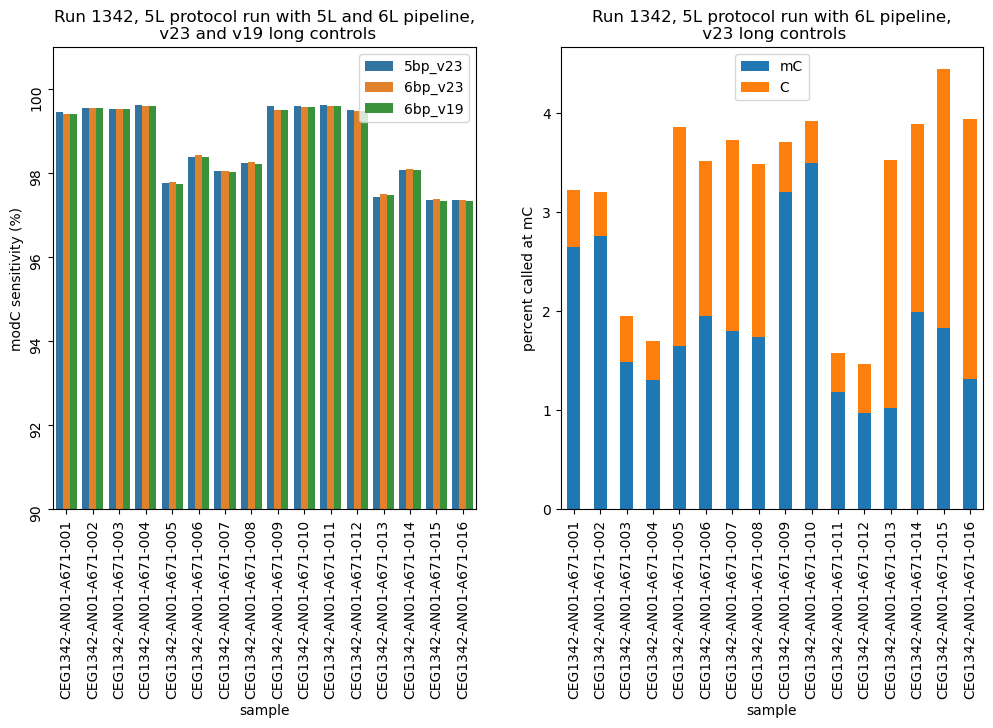

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(ax=axs[0], data=df_run1342, x="sample_name", y="dqs_lambda_modc_sensitivity", hue="seq_mode_and_long_ctrls_version")
axs[0].tick_params(rotation=90)
#plt.xticks(rotation=90)
axs[0].set_ylim(90, 101)
axs[0].set_xlabel("sample")
axs[0].set_ylabel("modC sensitivity (%)")
axs[0].legend(loc='upper right')
axs[0].set_title("Run 1342, 5L protocol run with 5L and 6L pipeline,\n v23 and v19 long controls")

df_percents.plot(ax=axs[1], x="sample_name", kind="bar", stacked=True)
axs[1].legend(['mC', 'C'], loc='upper center')
axs[1].set_xlabel("sample")
axs[1].set_ylabel("percent called at mC")
axs[1].set_title("Run 1342, 5L protocol run with 6L pipeline,\n v23 long controls")

# Run 1256

In [45]:
# Get 6L run data
df_6L = df_narrow_rem_dup_pt.loc[
    (df_narrow_rem_dup_pt["run_id"] == "CEG1256") & 
    (df_narrow_rem_dup_pt["pipeline_version"] == "1.0.7") &
    (df_narrow_rem_dup_pt["seq_mode"] == "6bp") &
    ((df_narrow_rem_dup_pt["sample_name"].str.contains("ML01")) | (df_narrow_rem_dup_pt["sample_name"].str.contains("LA01")))
]

print(df_6L["tower_run_date"].unique())

# Get 5L run data
df_5L = df_narrow_rem_dup_pt.loc[
    (df_narrow_rem_dup_pt["run_id"] == "CEG1256") & 
    (df_narrow_rem_dup_pt["pipeline_version"] == "1.0.7") &
    (df_narrow_rem_dup_pt["seq_mode"] == "5bp") &
    ((df_narrow_rem_dup_pt["sample_name"].str.contains("ML01")) | (df_narrow_rem_dup_pt["sample_name"].str.contains("LA01")))
]

print(df_5L["tower_run_date"].unique())

# df_5L["long_ctrls_version"] = "v23"
df_5L["dqs_lambda_modc_sensitivity"] = df_5L["dqs_lambda_sensitivity"]


# # Combine
df_run1256 = pd.concat([df_5L, df_6L]).copy()
df_run1256["sample_grouped"] = df_run1256["sample_name"].str[0:12] + "-XXXX-" + df_run1256["sample_name"].str[18:]
df_run1256["seq_mode_and_suffix"] = df_run1256["seq_mode"].str[0:12] + "_" + df_run1256["sample_name"].str[13]
print(df_run1256["sample_grouped"].head())
print(df_run1256["seq_mode_and_suffix"].head())
print(df_run1256[["sample_name", "dqs_lambda_modc_sensitivity"]].head())


['2023-02-24T19:12:00.000000000']
['2023-02-24T18:07:00.000000000']
8554    CEG1256-LA01-XXXX-001
8555    CEG1256-LA01-XXXX-002
8556    CEG1256-LA01-XXXX-003
8557    CEG1256-LA01-XXXX-004
8558    CEG1256-LA01-XXXX-005
Name: sample_grouped, dtype: object
8554    5bp_A
8555    5bp_A
8556    5bp_A
8557    5bp_A
8558    5bp_A
Name: seq_mode_and_suffix, dtype: object
col_name            sample_name dqs_lambda_modc_sensitivity
8554      CEG1256-LA01-A463-001          0.9768080995277382
8555      CEG1256-LA01-A463-002           0.968707256762483
8556      CEG1256-LA01-A463-003          0.9701142444265265
8557      CEG1256-LA01-A463-004          0.9715667666026788
8558      CEG1256-LA01-A463-005          0.9747607046082679


/tmp/ipykernel_2614/3950722589.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5L["dqs_lambda_modc_sensitivity"] = df_5L["dqs_lambda_sensitivity"]


In [46]:
df_run1256["dqs_lambda_modc_sensitivity"] = 100 * df_run1256["dqs_lambda_modc_sensitivity"].astype(float)
df_run1256["dqs_lambda_percent_mc_at_mc"] = 100 * df_run1256["dqs_lambda_percent_mc_at_mc"].astype(float)
df_run1256["dqs_lambda_percent_hmc_at_mc"] = 100 * df_run1256["dqs_lambda_percent_hmc_at_mc"].astype(float)
df_run1256["dqs_lambda_percent_c_at_mc"] = 100 * df_run1256["dqs_lambda_percent_c_at_mc"].astype(float)

df_percents = df_run1256.loc[(df_run1256["seq_mode_and_suffix"] == "6bp_A")][
    ["sample_name", 
     "dqs_lambda_percent_mc_at_mc",
     "dqs_lambda_percent_c_at_mc"]]
df_percents

col_name,sample_name,dqs_lambda_percent_mc_at_mc,dqs_lambda_percent_c_at_mc
8602,CEG1256-LA01-A463-001,0.358229,2.333044
8603,CEG1256-LA01-A463-002,0.391082,3.136101
8604,CEG1256-LA01-A463-003,0.411085,2.985558
8605,CEG1256-LA01-A463-004,0.426019,2.845417
8606,CEG1256-LA01-A463-005,0.384675,2.532141
8607,CEG1256-LA01-A463-006,0.380088,2.873884
8608,CEG1256-LA01-A463-007,0.393613,3.132028
8609,CEG1256-LA01-A463-008,0.405150,2.556040
8610,CEG1256-ML01-A464-001,0.651464,1.925065
8611,CEG1256-ML01-A464-002,0.694045,1.899412


8554    97.680810
8555    96.870726
8556    97.011424
8557    97.156677
8558    97.476070
          ...    
8629    97.617200
8630    97.422300
8631    97.386300
8632    97.359500
8633    97.190000
Name: dqs_lambda_modc_sensitivity, Length: 64, dtype: float64


Text(0.5, 1.0, 'Run 1256, 5L protocol run with 6L pipeline')

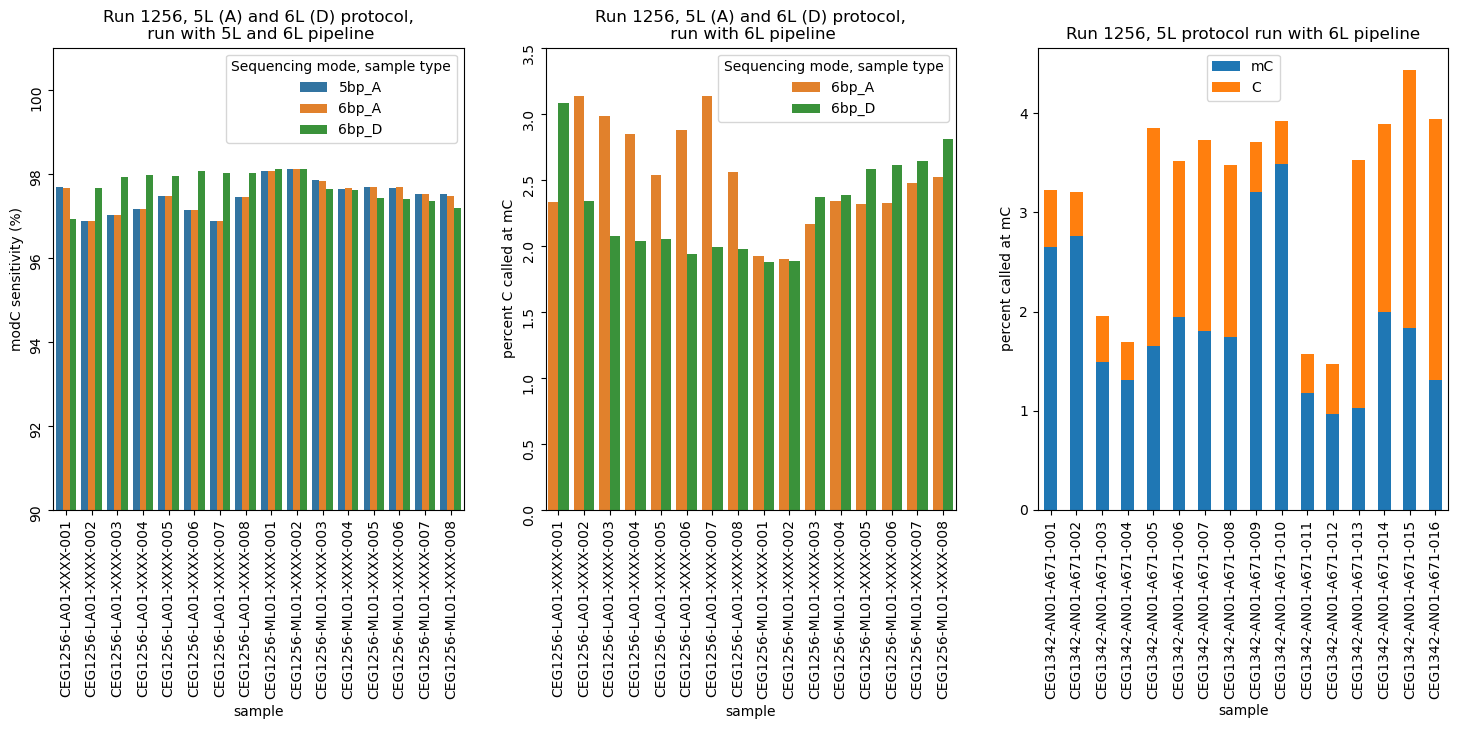

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

print(df_run1256["dqs_lambda_modc_sensitivity"])

color_key = {"5bp_A" : sns.color_palette()[0], 
             "6bp_A" : sns.color_palette()[1],
             "6bp_D" : sns.color_palette()[2]}

sns.barplot(ax=axs[0], data=df_run1256.loc[df_run1256["seq_mode_and_suffix"] != "5bp_D"], 
            x="sample_grouped", y="dqs_lambda_modc_sensitivity", hue="seq_mode_and_suffix")
axs[0].tick_params(rotation=90)
#plt.xticks(rotation=90)
axs[0].set_ylim(90, 101)
axs[0].set_xlabel("sample")
axs[0].set_ylabel("modC sensitivity (%)")
axs[0].legend(title='Sequencing mode, sample type')
axs[0].set_title("Run 1256, 5L (A) and 6L (D) protocol,\n run with 5L and 6L pipeline")


sns.barplot(ax=axs[1], data=df_run1256.loc[df_run1256["seq_mode"] != "5bp"], 
            x="sample_grouped", y="dqs_lambda_percent_c_at_mc", 
            hue="seq_mode_and_suffix", palette=color_key)

axs[1].set_ylim(0, 3.5)
axs[1].tick_params(rotation=90)
axs[1].set_xlabel("sample")
axs[1].set_ylabel("percent C called at mC")
axs[1].legend(title='Sequencing mode, sample type')
axs[1].set_title("Run 1256, 5L (A) and 6L (D) protocol,\n run with 6L pipeline")

df_percents.plot(ax=axs[2], x="sample_name", kind="bar", stacked=True)
axs[2].legend(['mC', 'C'], loc='upper center')
axs[2].set_xlabel("sample")
axs[2].set_ylabel("percent called at mC")
axs[2].set_title("Run 1256, 5L protocol run with 6L pipeline")